# Models

In this notebook, we will be using a decision tree to predict Medicaid spending on a specific drug given the brand, manufacturer, and generic names as well as data from the previous year. In particular, we will use 2019 data to predict spending in 2020, using the other data for training. 

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy 

from sklearn.preprocessing import MinMaxScaler, StandardScaler

#Models Used 
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.linear_model import SGDRegressor

from sklearn.pipeline import make_pipeline #used for scaling the input

from sklearn import metrics

## Setup

We first load our feature matrices and labels. 

In [2]:
#training feature matrix 
X = pd.read_csv('X.csv')
X

,Brnd_Name,Gnrc_Name,Mftr_Name,Tot_Dsg_Unts,Tot_Clms,Avg_Spnd_Per_Dsg_Unt_Wghtd,Avg_Spnd_Per_Clm
0,0,0,0,2426.26,1189,15.28,29.03
1,0,0,1,2426.26,1189,15.28,29.03
2,1,1,0,1613893.00,27596,4.56,266.73
3,1,1,2,504740.00,8520,4.51,267.43
4,1,1,3,636555.00,10946,4.53,263.63
...,...,...,...,...,...,...,...
25258,2550,1165,64,98239.00,2639,22.26,836.75
25259,2551,1165,0,345316.55,9343,22.88,719.38
25260,2551,1165,501,345316.55,9343,22.88,719.38
25261,2552,1664,0,887417.00,9362,105.69,9027.92


In [3]:
#training labels 
Y = pd.read_csv('Y.csv')
Y

,0
0,34520.89
1,34520.89
2,7360772.93
3,2278494.02
4,2885686.73
...,...
25258,2208171.01
25259,6721211.74
25260,6721211.74
25261,84519375.17


In [4]:
#test feature matrix
Xtest = pd.read_csv('Xtest.csv')
Xtest

,Brnd_Name,Gnrc_Name,Mftr_Name,Tot_Dsg_Unts,Tot_Clms,Avg_Spnd_Per_Dsg_Unt_Wghtd,Avg_Spnd_Per_Clm
0,0,0,0,275.00,179,1675.15,2025.17
1,0,0,1,275.00,179,1675.15,2025.17
2,1,1,0,1622835.00,15999,2.28,152.98
3,1,1,2,677310.00,5998,2.20,156.32
4,1,1,3,221192.00,3942,2.48,139.04
...,...,...,...,...,...,...,...
8416,2550,1165,64,83418.00,2416,23.20,835.30
8417,2551,1165,0,295501.76,8879,28.83,761.28
8418,2551,1165,501,295501.76,8879,28.83,761.28
8419,2552,1664,0,344872.00,4850,158.55,10231.95


In [5]:
#test labels 
Ytest = pd.read_csv('Ytest.csv')
Ytest

,Tot_Spndng_2020
0,11160.11
1,11160.11
2,1668418.74
3,741734.29
4,326056.77
...,...
8416,1880206.77
8417,5312667.87
8418,5312667.87
8419,34807960.04


In [6]:
np.median(Ytest)

301058.97

Our next step is to convert the dataframes into matrices. Then, we will be ready to train our models.

In [7]:
X_train = X.values
Y_train = Y.values
X_train

array([[0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.18900e+03,
        1.52800e+01, 2.90300e+01],
       [0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 1.18900e+03,
        1.52800e+01, 2.90300e+01],
       [1.00000e+00, 1.00000e+00, 0.00000e+00, ..., 2.75960e+04,
        4.56000e+00, 2.66730e+02],
       ...,
       [2.55100e+03, 1.16500e+03, 5.01000e+02, ..., 9.34300e+03,
        2.28800e+01, 7.19380e+02],
       [2.55200e+03, 1.66400e+03, 0.00000e+00, ..., 9.36200e+03,
        1.05690e+02, 9.02792e+03],
       [2.55200e+03, 1.66400e+03, 2.74000e+02, ..., 6.21800e+03,
        7.93800e+01, 9.03539e+03]])

In [8]:
Y_train

array([[3.45208900e+04],
       [3.45208900e+04],
       [7.36077293e+06],
       ...,
       [6.72121174e+06],
       [8.45193752e+07],
       [5.61820394e+07]])

In [9]:
X_test = Xtest.values
Y_test = Ytest.values

In [10]:
X_test

array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.790000e+02,
        1.675150e+03, 2.025170e+03],
       [0.000000e+00, 0.000000e+00, 1.000000e+00, ..., 1.790000e+02,
        1.675150e+03, 2.025170e+03],
       [1.000000e+00, 1.000000e+00, 0.000000e+00, ..., 1.599900e+04,
        2.280000e+00, 1.529800e+02],
       ...,
       [2.551000e+03, 1.165000e+03, 5.010000e+02, ..., 8.879000e+03,
        2.883000e+01, 7.612800e+02],
       [2.552000e+03, 1.664000e+03, 0.000000e+00, ..., 4.850000e+03,
        1.585500e+02, 1.023195e+04],
       [2.552000e+03, 1.664000e+03, 2.740000e+02, ..., 1.180000e+03,
        8.474000e+01, 9.746320e+03]])

In [11]:
Y_test

array([[1.11601100e+04],
       [1.11601100e+04],
       [1.66841874e+06],
       ...,
       [5.31266787e+06],
       [3.48079600e+07],
       [5.61260308e+06]])

## Decision Tree: Best Model 

The decision tree regressor outperformed other models by a lot. 

In [12]:
tr = tree.DecisionTreeRegressor()
treemodel = tr.fit(X_train, Y_train)

In [13]:
tr.score(X_train, Y_train)

1.0

In [14]:
preds = treemodel.predict(X_test)

In [15]:
metrics.mean_absolute_error(preds, Y_test)
print('Median absolute error: ' + str(metrics.median_absolute_error(preds, Y_test)))
print('R2 score: ' + str(metrics.r2_score(preds, Y_test)))
print('Median Medicare spending:' + str(np.median(Y_test)))

Median absolute error: 97871.15999999997
R2 score: 0.871414811515867
Median Medicare spending:301058.97


To visualize some results, we can look at the first 10 entries in our test feature matrix. Below is some information about these entries. 

**Entry 1**: Brand name: 8hr Arthristic Pain, generic name: Acetaminophen, manufacturer name: Overall
<br>

**Entry 2**: Brand name: 8hr Arthristic Pain, generic name: Acetaminophen, manufacturer name: Topco
<br>

**Entry 3**: Brand name: A & D, generic name: Vitamins A and D, manufacturer name: Overall
<br>

**Entry 4**: Brand name: A & D, generic name: Vitamins A and D, manufacturer name: Schering-Plough
<br>

**Entry 5**: Brand name: A And D, generic name: Vitamins A and D/ White Pet/ Lanolin, manufacturer name: Overall
<br>

**Entry 6**: Brand name: A And D, generic name: Vitamins A and D/ White Pet/ Lanolin, manufacturer name: Bayer Healthcare
<br>

**Entry 7**: Brand name: A and D, generic name: Diaper Rash Dimethic/Zinc Ox/Vits A,D/Aloe, manufacturer name: Overall
<br>

**Entry 8**: Brand name: A and D, generic name: Diaper Rash Dimethic/Zinc Ox/Vits A,D/Aloe, manufacturer name: Bayer Healthcare
<br>

**Entry 9**: Brand name: A-Hydrocort, generic name:	Hydrocortisone Sodium Succinate, manufacturer: Overall
<br>

**Entry 10**: Brand name: A-Hydrocort, generic name: Hydrocortisone Sod Succinate, manufacturer name: Hospira/Pfizer

In [16]:
pred_df = pd.DataFrame(preds)

In [17]:
pred10_df = pred_df.iloc[:10, :]
pred10_df

,0
0,335417.23
1,335417.23
2,2507666.58
3,936906.69
4,569109.18
5,127316.06
6,452010.80
7,4137687.93
8,302434.84
9,602800.01


In [18]:
actual10_df = Ytest.iloc[: 10, :]
actual10_df

,Tot_Spndng_2020
0,11160.11
1,11160.11
2,1668418.74
3,741734.29
4,326056.77
5,19480.06
6,256538.90
7,3063316.88
8,55050.20
9,775718.23


In [19]:
import seaborn as sns

preds = pd.concat([pred10_df, actual10_df], axis=1)
preds = preds.rename(columns={0: 'Predicted', 'Tot_Spndng_2020': 'Actual'})
preds['index'] = preds.index
preds

,Predicted,Actual,index
0,335417.23,11160.11,0
1,335417.23,11160.11,1
2,2507666.58,1668418.74,2
3,936906.69,741734.29,3
4,569109.18,326056.77,4
5,127316.06,19480.06,5
6,452010.80,256538.90,6
7,4137687.93,3063316.88,7
8,302434.84,55050.20,8
9,602800.01,775718.23,9


Text(0, 0.5, 'Medicaid Spending')

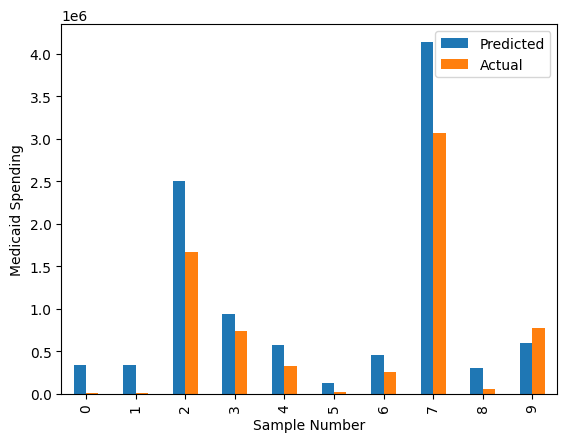

In [21]:
preds.plot(x="index", y=["Predicted", "Actual"], kind="bar")
plt.xlabel('Sample Number')
plt.ylabel('Medicaid Spending')

### Ensemble methods: bagging and boosting 

As seen by the graph, while most predictions achieve acurracy within half a million dollars, there is room for improvement. So I tried a few ensemble methods. 

#### Bagging

First, I tried bagging. 

In [25]:
y_train = Y_train.ravel()

In [23]:
#bagging = BaggingRegressor(tr, max_samples=0.5, max_features=0.5) #achieved 70% acurracy 
bagging = BaggingRegressor(tr)

In [26]:
bagtree = bagging.fit(X_train, y_train)

In [27]:
bagpred = bagtree.predict(X_test)

In [28]:
print('Median absolute error: ' + str(metrics.median_absolute_error(bagpred, Y_test)))

Median absolute error: 98657.41000000003


In [29]:
print(bagging.score(X_train, y_train))

0.9940150354951011


In [30]:
print(bagging.score(X_test, Y_test))

0.8887957039726153


It appears that bagging does not significantly change the accuracy. Changing the parameters of bagging (see commented out code), however, yielded lower results, so I ended up just using the default parameters. 

#### Boosting 

Next, I tried boosting, but the results were worse. 

In [32]:
m = AdaBoostRegressor(n_estimators=15)

In [33]:
adaboost = m.fit(X_train, y_train)

In [34]:
adaboost.score(X_train, y_train)

0.7897355107702098

In [35]:
adapred = adaboost.predict(X_test)
print('Median absolute error: ' + str(metrics.median_absolute_error(adapred, Y_test)))

Median absolute error: 8085436.839641658


### Ensemble method: majority vote 

I also tried a majority vote regressor, using my top 3 performers (KNN, SVM, and decision tree regressors). It did not perform as well as the decision tree regressor, likely due to the fact that the other two regressors did not perform as well. 

In [478]:
# Training classifiers
knn = KNeighborsRegressor(n_neighbors=5)
votereg = VotingRegressor(estimators=[('gb', treemodel), ('rf', knn), ('lr', svmmodel)])
votereg = votereg.fit(X_train, y_train)

In [479]:
votepred = votereg.predict(X_test)
print('R2 score: ' + str(votereg.score(X_test, Y_test)))
print('Median absolute error: ' + str(metrics.median_absolute_error(votepred, Y_test)))

R2 score: 0.5479414656818276
Median absolute error: 324999.069549565


Below is an illustrative plot with the predicted values for the three models as well as the actual value (shown in magenta).

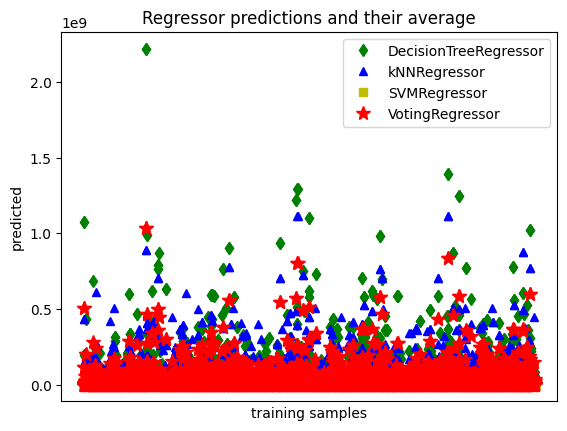

In [485]:
pred1 = treemodel.predict(X_train)
knn.fit(X_train, Y_train)
pred2 = knn.predict(X_train)
pred3 = svmmodel.predict(X_train)
pred4 = votereg.predict(X_train)

plt.figure()
plt.plot(pred1, "gd", label="DecisionTreeRegressor")
plt.plot(pred2, "b^", label="kNNRegressor")
plt.plot(pred3, "ys", label="SVMRegressor")
plt.plot(pred4, "r*", ms=10, label="VotingRegressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()

We see that in general, the voting regressor was not good for outliers, as it tended to predict all values to be less than 1 million. The actual values of the test data, seen below, appear to show more variability than the predictions from the voting regressor. The decision tree regressor, on the other hand, captured the variability better. 

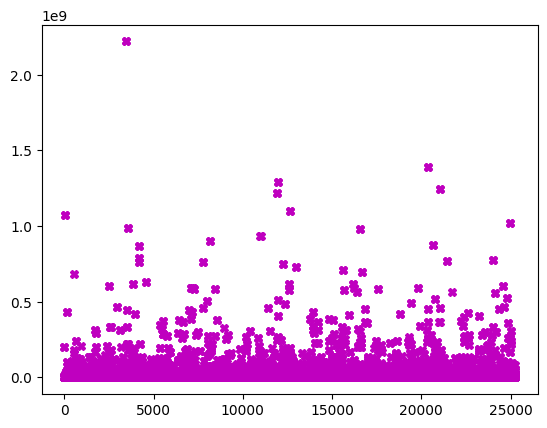

In [486]:
plt.plot(Y_train, "mX", label="ActualSpending")
plt.show()

## Other models 

The other models that are standard in the field that I tried were not as successful as the decision tree regressor- not even the Perceptron! 

### Nearest Neighbors Regressor 

The first regressor I tried was the kNN regressor, which is simple and quick to implement. Usually, the advice is to try the square root of the sample size as the number of neighbors, so I ran kNN using various numbers close to 158. Then, I realized that if I decreased the number of neighbors, the MAE decreased as well, so I ended up testing the model for the full range of neighbors from 1 to 180, achieving 350,728 as the minimum MAE, which is still higher than the decision tree model MAE. Additionally, the $R^2$ scores were much lower. 

In [470]:
knn_r_acc = []

for i in range(1,80,1):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train,Y_train)
    test_score = knn.score(X_test,Y_test)
    knnpred = knn.predict(X_test)
    train_score = knn.score(X_train,Y_train)
    mse = metrics.median_absolute_error(knnpred, Y_test)
    knn_r_acc.append((i, test_score ,train_score, mse))
df = pd.DataFrame(knn_r_acc, columns=['K','Test Score','Train Score', 'MSE'])
print(df)

     K  Test Score  Train Score            MSE
0    1   -0.149832     1.000000  350728.760000
1    2   -0.197376     0.939419  382183.520000
2    3   -0.033292     0.796533  425457.986667
3    4    0.011511     0.697518  464766.895000
4    5    0.008146     0.631128  490777.104000
..  ..         ...          ...            ...
74  75    0.113607     0.167900  886115.547733
75  76    0.113455     0.166780  896606.630395
76  77    0.113588     0.165770  900574.578961
77  78    0.113309     0.165087  913635.656923
78  79    0.114145     0.164297  913270.800127

[79 rows x 4 columns]


In [476]:
min(df['MSE']) #minimum MSE for 1 - 80 neighbors 

350728.76

In [469]:
knn_r_acc = []

for i in range(80,120,1):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train,Y_train)
    test_score = knn.score(X_test,Y_test)
    knnpred = knn.predict(X_test)
    train_score = knn.score(X_train,Y_train)
    mse = metrics.median_absolute_error(knnpred, Y_test)
    knn_r_acc.append((i, test_score ,train_score, mse))
df = pd.DataFrame(knn_r_acc, columns=['K','Test Score','Train Score', 'MSE'])
print(df)

      K  Test Score  Train Score           MSE
0    80    0.114681     0.163818  9.283541e+05
1    81    0.113618     0.164103  9.400526e+05
2    82    0.114783     0.163990  9.455068e+05
3    83    0.116894     0.162939  9.597270e+05
4    84    0.117151     0.161735  9.577502e+05
5    85    0.116744     0.161236  9.620335e+05
6    86    0.116328     0.160860  9.624044e+05
7    87    0.115431     0.160359  9.706237e+05
8    88    0.114627     0.160139  9.747260e+05
9    89    0.114234     0.159680  9.757775e+05
10   90    0.114157     0.159026  9.744968e+05
11   91    0.113797     0.158490  9.703953e+05
12   92    0.112735     0.157700  9.805683e+05
13   93    0.112496     0.156699  9.888850e+05
14   94    0.112487     0.155664  9.944291e+05
15   95    0.112305     0.154866  9.908855e+05
16   96    0.111706     0.153896  9.878611e+05
17   97    0.110780     0.152958  9.839637e+05
18   98    0.109880     0.152621  9.888762e+05
19   99    0.108970     0.152718  9.969404e+05
20  100    0.

In [467]:
knn_r_acc = []

for i in range(120,150,1):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train,Y_train)
    test_score = knn.score(X_test,Y_test)
    knnpred = knn.predict(X_test)
    train_score = knn.score(X_train,Y_train)
    mse = metrics.median_absolute_error(knnpred, Y_test)
    knn_r_acc.append((i, test_score ,train_score, mse))
df = pd.DataFrame(knn_r_acc, columns=['K','Test Score','Train Score', 'MSE'])
print(df)

      K  Test Score  Train Score           MSE
0   120    0.110733     0.139297  1.052701e+06
1   121    0.110643     0.138950  1.054482e+06
2   122    0.110910     0.138949  1.053854e+06
3   123    0.111508     0.138531  1.062280e+06
4   124    0.111016     0.137853  1.062312e+06
5   125    0.110331     0.137005  1.064161e+06
6   126    0.110050     0.136174  1.068147e+06
7   127    0.110631     0.135434  1.077805e+06
8   128    0.111868     0.134781  1.080331e+06
9   129    0.111247     0.134269  1.088451e+06
10  130    0.110539     0.133715  1.110136e+06
11  131    0.109951     0.133434  1.116709e+06
12  132    0.109598     0.133061  1.131261e+06
13  133    0.109328     0.132515  1.122044e+06
14  134    0.109272     0.131862  1.125835e+06
15  135    0.109657     0.131701  1.126438e+06
16  136    0.110061     0.131508  1.122266e+06
17  137    0.110270     0.131322  1.133948e+06
18  138    0.111328     0.131176  1.128300e+06
19  139    0.111910     0.130760  1.135656e+06
20  140    0.

In [468]:
knn_r_acc = []

for i in range(150,180,1):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train,Y_train)
    test_score = knn.score(X_test,Y_test)
    knnpred = knn.predict(X_test)
    train_score = knn.score(X_train,Y_train)
    mse = metrics.median_absolute_error(knnpred, Y_test)
    knn_r_acc.append((i, test_score ,train_score, mse))
df = pd.DataFrame(knn_r_acc, columns=['K','Test Score','Train Score', 'MSE'])
print(df)

      K  Test Score  Train Score           MSE
0   150    0.107868     0.127979  1.154461e+06
1   151    0.107792     0.128023  1.155815e+06
2   152    0.107225     0.127794  1.162206e+06
3   153    0.106679     0.127309  1.184620e+06
4   154    0.106162     0.126797  1.185870e+06
5   155    0.105847     0.126144  1.184871e+06
6   156    0.105564     0.125602  1.190389e+06
7   157    0.104923     0.125015  1.194250e+06
8   158    0.104432     0.124771  1.194826e+06
9   159    0.104129     0.124535  1.192329e+06
10  160    0.103960     0.124146  1.196099e+06
11  161    0.103718     0.123949  1.193377e+06
12  162    0.103324     0.123516  1.205722e+06
13  163    0.103459     0.123013  1.207239e+06
14  164    0.103869     0.122654  1.205973e+06
15  165    0.103819     0.122367  1.219260e+06
16  166    0.103550     0.122189  1.223451e+06
17  167    0.103085     0.121783  1.252242e+06
18  168    0.102427     0.121274  1.248046e+06
19  169    0.101807     0.120639  1.243644e+06
20  170    0.

### Linear Regressors 

I also tried some basic linear regressors, which performed the worst of all the models I tried. The Perceptron outperformed the classic linear regressors (unsurprisingly), but did not perform significantly better than kNN. First on the list was the classic linear regression model. 

In [36]:
linreg = linear_model.LinearRegression()
linmodel = linreg.fit(X_train, Y_train)

In [38]:
print(linmodel.score(X_test, Y_test))

0.0784861916347751


In [40]:
linpred = linmodel.predict(X_test)
print('Median absolute error:' + str(metrics.median_absolute_error(linpred, Y_test)))

Median absolute error:7585091.394977176


Next, I tried ridge regression, achieving about the same MAE. 

In [460]:
ridgereg = linear_model.Ridge(alpha=.5)
ridgemodel = ridgereg.fit(X_train, Y_train)

In [461]:
print(ridgemodel.score(X_test, Y_test))

0.07848619163466375


In [462]:
ridgepreds = ridgemodel.predict(X_test)
print('Median absolute error: ' + str(metrics.median_absolute_error(ridgepreds, Y_test)))

Median absolute error: 7585091.395852613


Finally, I tried the Perceptron regressor, which took longer to train and yielded much better accuracy than the classical regressors, but the MAE was still quite high. 

In [248]:
from sklearn.neural_network import MLPRegressor
perceptronmodel = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
#perceptronmodel.score(X_train, y_train)
#perceptronmodel.predict(X_test[:2])
#regr.score(X_test, y_test)

In [249]:
Xtrain = StandardScaler().fit_transform(X_train) #Each feature of equal importance
Xtrain = MinMaxScaler().fit_transform(X_train) #scale all features to given range (default appears to be 0 to 1)

In [250]:
perceppred = perceptronmodel.predict(X_test)

In [79]:
perceptronmodel.score(X_test, Y_test)

0.1571260627609482

In [437]:
metrics.median_absolute_error(perceppred, Y_test)
#metrics.mean_squared_error(perceppred, Y_test)

3134041.164885473

### Stochastic Gradient Descent Regressor

The stochastic gradient descent (SGD) regressor did not perform very well. 

In [41]:
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=100, tol=1e-3))
reg.fit(X_train, Y_train.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor(max_iter=100))])

In [42]:
#R2 score of regressor 
reg.score(X_train, Y_train.ravel())

0.09511458371422865

In [43]:
sgdpred = reg.predict(X_train)

In [44]:
print('Median Absolute Error: ' + str(metrics.median_absolute_error(sgdpred, Y_train)))

Median Absolute Error: 6678112.121793327


### Support Vector Machine 

Support vector machines are another popular model that are said to perform on the caliber of neural nets, so I decided to give them a try. While SVM performed better than some of the other models I tried, the decision tree model still yielded better results. 

In [45]:
r = make_pipeline(StandardScaler(), svm.SVR()) #scaling 
svmmodel = r.fit(X_train, y_train)

In [46]:
svmpred=svmmodel.predict(X_test)

The $R^2$ score of the SVM is not very high.

In [47]:
print(svmmodel.score(X_test,Y_test))

-0.037496450818946814


In [48]:
print(metrics.median_absolute_error(svmpred, Y_test))

615257.3390554702


## After SMOGN

I tested my top performing models with SMOGN data. First, I tried with decision trees. 

### Decision Tree and SMOGN

In [55]:
Xbal = pd.read_csv('Xbal.csv')
Xbal

,Brnd_Name,Gnrc_Name,Mftr_Name,Tot_Dsg_Unts,Tot_Clms,Avg_Spnd_Per_Dsg_Unt_Wghtd,Avg_Spnd_Per_Clm
0,1605,649,63,6.762309e+07,695772,0.080000,9.875346
1,415,347,15,1.215973e+08,840729,0.060000,8.880000
2,2161,1461,0,8.211420e+05,25694,29.860000,915.590000
3,2161,1461,256,8.211420e+05,25694,29.860000,915.590000
4,779,606,3,1.457732e+07,449817,0.260741,8.514812
...,...,...,...,...,...,...,...
12906,2544,253,500,4.944574e+06,189542,8.670000,225.550000
12907,2551,1165,0,3.453165e+05,9343,22.880000,719.380000
12908,2551,1165,501,3.453165e+05,9343,22.880000,719.380000
12909,2552,1664,0,8.874170e+05,9362,105.690000,9027.920000


In [56]:
Ybal = pd.read_csv('Ybal.csv')
Ybal

,Tot_Spndng
0,5.363024e+06
1,1.119897e+07
2,3.528764e+07
3,3.528764e+07
4,4.060972e+06
...,...
12906,4.275206e+07
12907,6.721212e+06
12908,6.721212e+06
12909,8.451938e+07


We now combine the original training data and the synthetic data. 

In [57]:
X_b = pd.concat([Xbal, X], axis=0)
X_b

,Brnd_Name,Gnrc_Name,Mftr_Name,Tot_Dsg_Unts,Tot_Clms,Avg_Spnd_Per_Dsg_Unt_Wghtd,Avg_Spnd_Per_Clm
0,1605,649,63,6.762309e+07,695772,0.080000,9.875346
1,415,347,15,1.215973e+08,840729,0.060000,8.880000
2,2161,1461,0,8.211420e+05,25694,29.860000,915.590000
3,2161,1461,256,8.211420e+05,25694,29.860000,915.590000
4,779,606,3,1.457732e+07,449817,0.260741,8.514812
...,...,...,...,...,...,...,...
25258,2550,1165,64,9.823900e+04,2639,22.260000,836.750000
25259,2551,1165,0,3.453165e+05,9343,22.880000,719.380000
25260,2551,1165,501,3.453165e+05,9343,22.880000,719.380000
25261,2552,1664,0,8.874170e+05,9362,105.690000,9027.920000


In [69]:
Ybal = Ybal.rename(columns={'Tot_Spndng': '0'})
Y_b = pd.concat([Ybal, Y], axis=0)

In [71]:
Xb = X_b.values
Yb = Y_b.values
baltree = tr.fit(Xb, Yb)

In [72]:
predbal = baltree.predict(X_test)

In [76]:
print('Median absolute error: ' + str(metrics.median_absolute_error(predbal, Y_test)))
print('R2 score: ' + str(baltree.score(X_test, Y_test)))

Median absolute error: 98649.94999999995
R2 score: 0.7629592298845578


As one can see, the MAE is unchanged while the R2 score decreased. 

### Support Vector Machine and SMOGN

I tried to see how SMOGN would affect the support vector machine. The accuracy appears to go down. 

In [79]:
r = make_pipeline(StandardScaler(), svm.SVR()) #scaling 
svmmodel = r.fit(Xb, Yb.ravel())

In [80]:
balsvm = svmmodel.predict(X_test)

In [81]:
print('Median absolute error: ' + str(metrics.median_absolute_error(balsvm, Y_test)))
print('R2 score: ' + str(svmmodel.score(X_test, Y_test)))

Median absolute error: 2855830.692731934
R2 score: -0.02390346171032598


## Overall Results 

Here is a table summarizing the results of the different models used. The classic linear regression model did not perform well (as suggested by the heat maps of the correlation matrix) while the decision tree regressor outperformed several ensemble methods. Bagging appeared to slightly improve the $R^2$ and MAE scores, but not significantly.
<br>

| Model | MSE | R2 Score | 
| --- | --- | --- |
| Decision Tree | 97871 | 0.8714 |
| Decision Tree + Bagging | 98657 | 0.8888 |
| Voting | 324999 | 0.5479 |
| Nearest Neighbors | 350729 | 1 |
| Support Vector Machine | 615257 | -0.03750 |
| Stochastic Gradient Descent | 7465638 | 0.09195 |
| Linear Regression | 7585091 | 0.07849 |
| adaBoost | 8085436 | 0.7897 |